This notebook evalutes a few simple metrics for the predicted votes output by the model. These include a quick look at the zero-vote vs. non-zero-vote accuracy (more relevant for hurdle models), an overall confusion matrix, and most importantly a distribution for the spearman's correlation coefficient across all mcmc sample, across all chains. This should be a reliable measure of whether or not there is any signal in the structure of the predictions.

In [2]:
import arviz as az
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import spearmanr

In [3]:
# load output from fitted model
az_fit = az.from_json("model_output/model_3_voter_bias_vector_1000_samples_3_chains_1998-2018.json")

In [4]:
# load y_test values to evaluate model predictions on unseen x_test data
with open('model_output/y_test_2019-2022.json') as f:
    y_test = f.read()
y_test = np.asarray(json.loads(y_test))
print(y_test.shape)

(3003,)


In [5]:
print(f'y_pred shape: ',az_fit.predictions.y_pred.to_numpy().shape)
y_pred = az_fit.predictions.y_pred.to_numpy()

y_pred shape:  (3, 1000, 3003)


Text(0.5, 1.0, 'y_pred (chain 1, sample 1)')

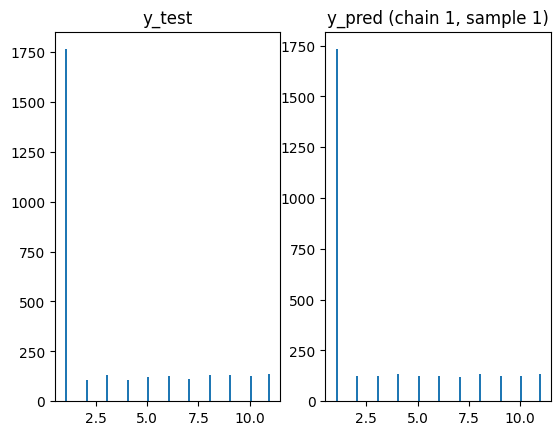

In [6]:
#  quick qualitative check for class balance in predictions
pltL = plt.subplot(1,2,1); pltR = plt.subplot(1,2,2)
pltL.hist(y_test,bins=100)
pltL.set_title('y_test')
pltR.hist(y_pred[0,0,:],bins=100)
pltR.set_title('y_pred (chain 1, sample 1)')


In [7]:
# treat each chain independently, and for each chain average prediction accuracies across the 2500 samples
chain_acc = []
for ci in range(y_pred.shape[0]):   # loop chains
    acc = 0
    for si in range(y_pred.shape[1]):   # loop samples
        acc += np.where(y_pred[ci,si,:] == y_test, True, False).sum() / y_test.shape[0]
    chain_acc.append(acc/y_pred.shape[1])
    
print(f'mean accuracy in each chain: ',chain_acc)

mean accuracy in each chain:  [0.3882400932400902, 0.3881308691308658, 0.3874948384948365]


Text(0.5, 23.52222222222222, 'Predicted label')

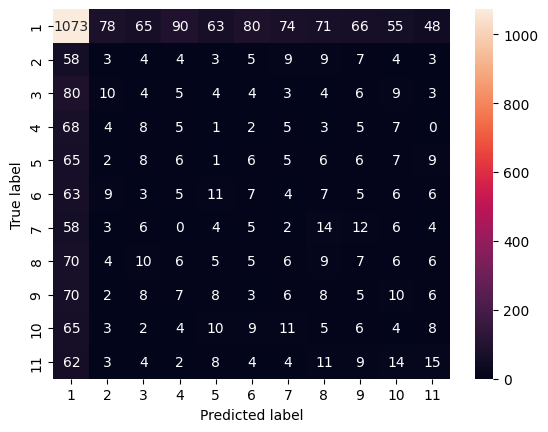

In [8]:
# confusion matrix for one of the prediction sets
cm = confusion_matrix(y_test, y_pred[0,1,:])
axislabels = [ f'{x}' for x in range(1,12) ]
sns.heatmap(cm, annot=True, fmt="d", xticklabels=axislabels,yticklabels=axislabels )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [9]:
# prepare accuracy metric for the zero hurdle component in the model
y_test_vote = np.where(y_test == 1,0,1)
y_pred_vote = np.zeros_like(y_pred)
for ci in range(y_pred.shape[0]):   # loop chains
    for si in range(y_pred.shape[1]):   # loop samples
        y_pred_vote[ci][si] = np.where(y_pred[ci,si,:] == 1, 0, 1)

chain_acc_vote = []
for ci in range(y_pred.shape[0]):   # loop chains
    acc = 0
    for si in range(y_pred.shape[1]):   # loop samples
        acc += np.where(y_pred_vote[ci,si,:] == y_test_vote, True, False).sum() / y_test.shape[0]
    chain_acc_vote.append(acc/y_pred.shape[1])

print(f'zero/non-zero vote accuracy per chain:',chain_acc_vote)

zero/non-zero vote accuracy per chain: [0.5626590076590051, 0.5627276057276036, 0.5619736929736913]


Note on zero/non-zero accuracy :
* could the binary logistic component of the model be improved by introducing different parameters to be used in the regression. Currently the same parameters are being used to map the covariates to the logit for the binary logistic regression and the ordinal regression.

Text(0.5, 23.52222222222222, 'Predicted label')

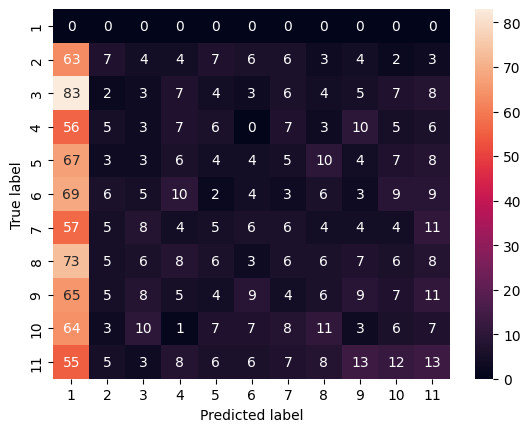

In [10]:
# analyse the non-zero modelling performance
y_test_non_z = y_test[y_test != 1]
y_pred_non_z = np.zeros((y_pred.shape[0],y_pred.shape[1],y_test_non_z.shape[0]))

for ci in range(y_pred.shape[0]):   # loop chains
    for si in range(y_pred.shape[1]):   # loop samples
        y_pred_non_z[ci][si] = y_pred[ci][si][y_test != 1]

cm = confusion_matrix(y_test_non_z, y_pred_non_z[0,0,:])
axislabels = [ f'{x}' for x in range(1,12) ]
sns.heatmap(cm, annot=True, fmt="d",xticklabels=axislabels,yticklabels=axislabels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [27]:
# before doing rank correlation, the variables should be re-mapped back to 0->12 (skipping 9 and 11)
def format_votes(x):
  if x == 10.:
    return 12
  elif x == 9.:
    return 10
  return int(x)
v_test = [ format_votes(x) for x in (y_test - 1) ]
v_pred = np.zeros_like(y_pred)
for c in range(y_pred.shape[0]):
  for d in range(y_pred.shape[1]):
    v_pred[c,d,:] = [ format_votes(x) for x in (y_pred[c,d,:] - 1) ]
print(f'y_test: {set(y_test)}')
print(f'v_test: {set(v_test)}')
print(f'y_pred: {set(y_pred[0][0])}')
print(f'v_pred: {set(v_pred[0][0])}')

v_test_non_z = [ format_votes(x) for x in (y_test_non_z - 1) ]
v_pred_non_z = np.zeros_like(y_pred_non_z)
for c in range(y_pred_non_z.shape[0]):
  for d in range(y_pred_non_z.shape[1]):
    v_pred_non_z[c,d,:] = [ format_votes(x) for x in (y_pred_non_z[c,d,:] - 1) ]

y_test: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
v_test: {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12}
y_pred: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0}
v_pred: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0}


In [24]:
spearmanr(v_test, v_pred[0][0])

SignificanceResult(statistic=0.1227006597846936, pvalue=1.5128866797610872e-11)

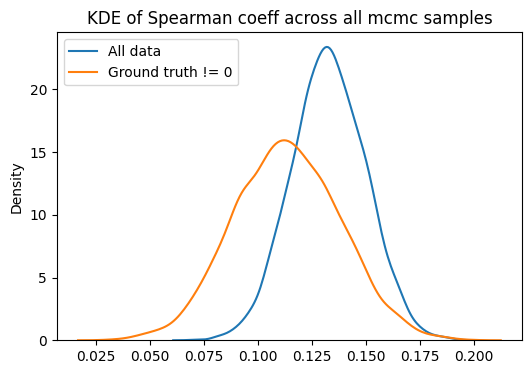

In [41]:
# evaluate spearmans rank corr coeff distribution across all the chains and samples
fig,ax = plt.subplots()

# all data
ro = np.zeros((v_pred.shape[0],v_pred.shape[1]))
for ci in range(v_pred.shape[0]):   # loop chains
    for si in range(v_pred.shape[1]):   # loop samples
        ro[ci][si] = spearmanr(v_test, v_pred[ci][si])[0]
sns.kdeplot(ro.flatten(),ax=ax)
ax.set_title('KDE of Spearman coeff across all mcmc samples')

# subset of data where ground truth vote != 0
ro_non_z = np.zeros((v_pred_non_z.shape[0],v_pred_non_z.shape[1]))
for ci in range(v_pred_non_z.shape[0]):   # loop chains
    for si in range(v_pred_non_z.shape[1]):   # loop samples
        ro_non_z[ci][si] = spearmanr(v_test_non_z, v_pred_non_z[ci][si])[0]
sns.kdeplot(ro_non_z.flatten(), ax=ax)
ax.legend(['All data', 'Ground truth != 0'])
fig.set_size_inches(6,4)
